## CIFAR-10 Project

### CNN with TensorFlow

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [1]:
# Put file path as a string here
CIFAR_DIR = 'D:/Self.Study/Udemy - Complete guide to Tensorflow - Jose Portilla/FULL-TENSORFLOW-NOTES-AND-DATA/Tensorflow-Bootcamp-master/03-Convolutional-Neural-Networks/cifar-10-batches-py/'

### Load the data

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [4]:
all_data = [0,1,2,3,4,5,6]

In [5]:
for i, direc in zip(all_data, dirs):
    all_data[i] = unpickle(CIFAR_DIR + direc)

In [6]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [7]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [8]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

### Display a single image using matplotlib.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [10]:
X = data_batch1[b"data"] 

In [11]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [12]:
X[0].max()

255

In [13]:
(X[0]/255).max()

1.0

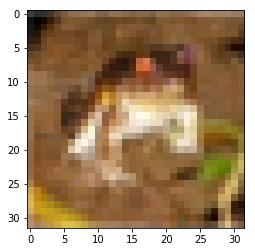

In [43]:
plt.imshow(X[0])

## Helper Functions for Dealing With Data.

In [14]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [15]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [16]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


### Creating the Model

#### Import tensorflow

In [17]:
import tensorflow as tf

C:\Users\kingsumedh\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


** Create 2 placeholders, x and y_true. Their shapes should be: **

* x shape = [None,32,32,3]
* y_true shape = [None,10]

In [18]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])

** Create one more placeholder called hold_prob. No need for shape here. This placeholder will just hold a single probability for the dropout. **

In [19]:
hold_prob = tf.placeholder(tf.float32)

### Helper Functions

** Grab the helper functions from MNIST with CNN (or recreate them here yourself for a hard challenge!). You'll need: **

* init_weights
* init_bias
* conv2d
* max_pool_2by2
* convolutional_layer
* normal_full_layer

In [20]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### Create the Layers

** Create a convolutional layer and a pooling layer as we did for MNIST. **
** Its up to you what the 2d size of the convolution should be, but the last two digits need to be 3 and 32 because of the 3 color channels and 32 pixels. So for example you could use:**

        convo_1 = convolutional_layer(x,shape=[4,4,3,32])

In [21]:
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

** Create the next convolutional and pooling layers.  The last two dimensions of the convo_2 layer should be 32,64 **

In [22]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

** Now create a flattened layer by reshaping the pooling layer into [-1,8 * 8 * 64] or [-1,4096] **

In [23]:
8*8*64

4096

In [24]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

** Create a new full layer using the normal_full_layer function and passing in your flattend convolutional 2 layer with size=1024. (You could also choose to reduce this to something like 512)**

In [25]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

** Now create the dropout layer with tf.nn.dropout, remember to pass in your hold_prob placeholder. **

In [26]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

** Finally set the output to y_pred by passing in the dropout layer into the normal_full_layer function. The size should be 10 because of the 10 possible labels**

In [27]:
y_pred = normal_full_layer(full_one_dropout,10)

### Loss Function

** Create a cross_entropy loss function **

In [28]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Optimizer
** Create the optimizer using an Adam Optimizer. **

In [36]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

** Create a variable to intialize all the global tf variables. **

In [37]:
init = tf.global_variables_initializer()

## Graph Session

** Perform the training and test print outs in a Tf session and run your model! **

In [39]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(20000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels, hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.1167


Currently on step 100
Accuracy is:
0.315


Currently on step 200
Accuracy is:
0.3811


Currently on step 300
Accuracy is:
0.4038


Currently on step 400
Accuracy is:
0.4273


Currently on step 500
Accuracy is:
0.4405


Currently on step 600
Accuracy is:
0.4601


Currently on step 700
Accuracy is:
0.4768


Currently on step 800
Accuracy is:
0.4817


Currently on step 900
Accuracy is:
0.4898


Currently on step 1000
Accuracy is:
0.4992


Currently on step 1100
Accuracy is:
0.5012


Currently on step 1200
Accuracy is:
0.5076


Currently on step 1300
Accuracy is:
0.5165


Currently on step 1400
Accuracy is:
0.5169


Currently on step 1500
Accuracy is:
0.5267


Currently on step 1600
Accuracy is:
0.5298


Currently on step 1700
Accuracy is:
0.5395


Currently on step 1800
Accuracy is:
0.5441


Currently on step 1900
Accuracy is:
0.5426


Currently on step 2000
Accuracy is:
0.5559


Currently on step 2100
Accuracy is:
0.5568


Currently on step 2200


Currently on step 18100
Accuracy is:
0.7075


Currently on step 18200
Accuracy is:
0.7115


Currently on step 18300
Accuracy is:
0.7047


Currently on step 18400
Accuracy is:
0.7024


Currently on step 18500
Accuracy is:
0.7076


Currently on step 18600
Accuracy is:
0.7098


Currently on step 18700
Accuracy is:
0.7082


Currently on step 18800
Accuracy is:
0.7066


Currently on step 18900
Accuracy is:
0.7026


Currently on step 19000
Accuracy is:
0.7103


Currently on step 19100
Accuracy is:
0.7127


Currently on step 19200
Accuracy is:
0.709


Currently on step 19300
Accuracy is:
0.7024


Currently on step 19400
Accuracy is:
0.7054


Currently on step 19500
Accuracy is:
0.7143


Currently on step 19600
Accuracy is:
0.7119


Currently on step 19700
Accuracy is:
0.7132


Currently on step 19800
Accuracy is:
0.7119


Currently on step 19900
Accuracy is:
0.7066


